# Lesson 2 : LangGraph Components

In [28]:
!pip install langchain langgraph langchain_openai langchain_community

In [29]:
!apt-get install graphviz libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

In [30]:
import os
from google.colab import userdata

# Set up your OpenAI API key
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# Set up your Tavily API key. Replace 'YOUR_TAVILY_API_KEY' with your actual key.
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

In [31]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [32]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [33]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [34]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [35]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

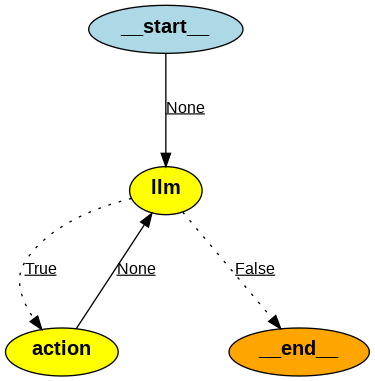

In [36]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [37]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_g8Gs1TSxwWd6xKCjL0T4jICS', 'type': 'tool_call'}
Back to the model!


In [38]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_g8Gs1TSxwWd6xKCjL0T4jICS', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d185b66c-10c2-4eff-9205-7e530b176f2e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_g8Gs1TSxwWd6xKCjL0T4jICS', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'l

In [39]:
result['messages'][-1].content

'The current weather in San Francisco is sunny with a temperature of 71.1°F. The wind speed is 20.2 kph coming from the west-northwest direction. The humidity is at 57%, and there is no precipitation at the moment.'

In [40]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_iNTBfZRpT0988p4DxDd0hLXo', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_yHlONwxvFLe4v1yWitwppPcE', 'type': 'tool_call'}
Back to the model!


In [41]:
result['messages'][-1].content

'The current weather in San Francisco is sunny with a temperature of 71.1°F and a wind speed of 20.2 km/h. The humidity is 57% and there is no precipitation.\n\nIn Los Angeles, the current weather is also sunny with a temperature of 91.9°F. The wind speed is 9.0 km/h, and the humidity is 31%. There is no precipitation in Los Angeles as well.'

In [42]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'who won the Super Bowl 2024'}, 'id': 'call_gZho1nTM04IayRBiM9Pv2ExQ', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of California 2023'}, 'id': 'call_ZfiojzcWFVGzmOW8R2uLYEIS', 'type': 'tool_call'}
Back to the model!


In [43]:
print(result['messages'][-1].content)

### Who won the Super Bowl in 2024?
The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers in an overtime victory.

### In what state is the winning team headquarters located?
The Kansas City Chiefs are headquartered in Kansas City, Missouri.

### What is the GDP of that state?
The GDP of Missouri was not directly provided in the search results, but I found the GDP of California, which is $3.9 trillion in 2023. For accurate information on Missouri's GDP, further specific search may be required.

Would you like me to search specifically for the GDP of Missouri?
